# TP - Non-parametric regression (Cubic splines)
<h4 align="right"> Author: Hicham Janati </h4>

The motorcycle dataset records the head's acceleration after an accident as a function of time. Download and visualize the data:

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib ipympl


url = "https://raw.githubusercontent.com/hichamjanati/hichamjanati.github.io/master/_data/Motorcycledata.txt"
names = ["x", "y"]
df_raw = pd.read_csv(url, index_col=0, delim_whitespace=True, names=names)
print(df_raw.shape)
df_raw.head()

(133, 2)


,x,y
1,2.4,0.0
2,2.6,-1.3
3,3.2,-2.7
4,3.6,0.0
5,4.0,-2.7


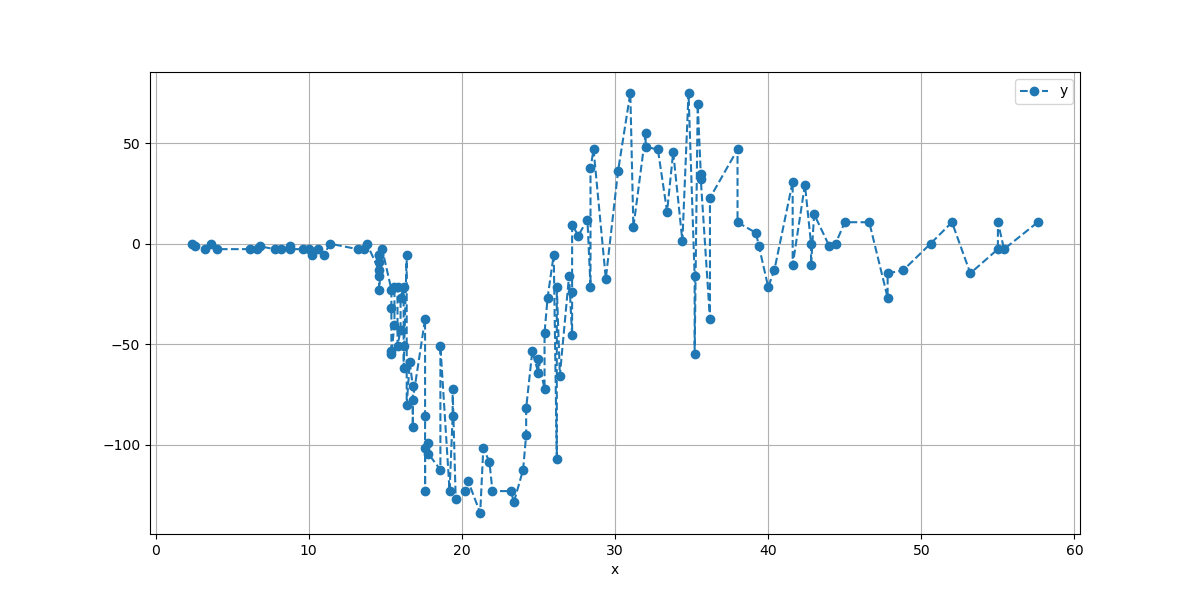

In [248]:
ax = df_raw.plot("x", "y", marker="o", ls="--", figsize=(12, 6))
ax.grid()

#### Question 1
Transform the data to variables $(x, y, w)$ such that duplicated values are handled and ready to be fed to a weighted spline regression (cf TD Questions 5-6). 

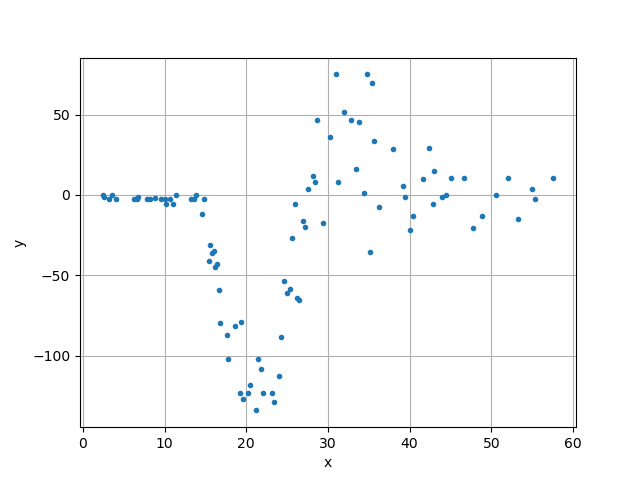

In [249]:
x_raw = df_raw["x"]
y_raw = df_raw["y"]

#get the unique x elements and the weight (that is the count of how many times it appears)
x, weights = np.unique(x_raw, return_counts=True)

weights_norm = weights/np.sum(weights)

# the new y vector is, the mean for the y values with a same x (for all x)
y = np.zeros(len(x))
for i in range(len(x)):
    y[i] = np.mean(y_raw[x_raw == x[i]])
    
fig, ax = plt.subplots()
plt.plot(x,y, ".")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()


### Polynomial regression
Polynomial regression (fitting a best polynomial on the data) can be done using `np.polyfit` to obtain the coefficients and `polyval` to evaluate it.

#### Question 2
Perform (weighted) polynomial regression on the data and visualize the fitted curves for degrees 1, 3, 10 on the same plot. Try higher degree polynomial fits. Besides overfitting, why is this potentially a bad idea ?

This is because when we have higher degree polynomial fits, then it happens that on the extremes of the function tend to infinity more quickly. This may cause a problem when trying to predict new data points based on these fits that where done.

Error with degre 1: 213979.20023991627
Error with degre 3: 153937.51548157184
Error with degre 10: 35744.23148027111
Error with degre 20: 31671.31075823593


/home/bruno/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


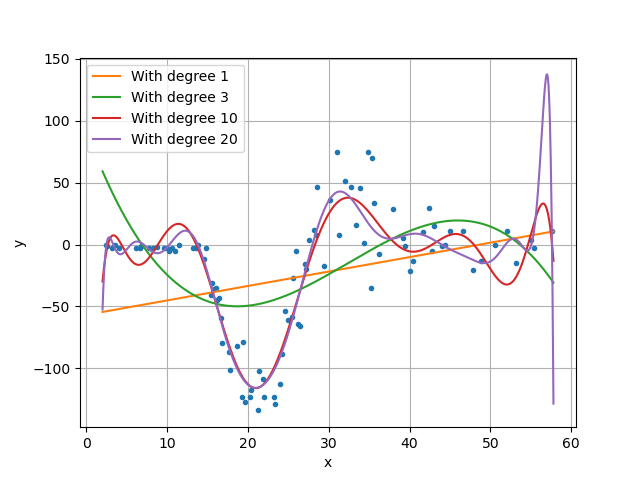

In [250]:
deg = np.array([1,3,10,20])

xx = np.linspace(2,57.8,1000)

fig, ax = plt.subplots()
plt.plot(x, y , ".")
for i in deg:
    coef = np.polyfit(x, y, i, w=weights)
    polyreg = np.poly1d(coef)
    error = np.sum( (np.polyval(polyreg, x) - y) **2 )
    plt.plot(xx, polyreg(xx), label = "With degree %s" % i)
    print("Error with degre %s: %s" % (i, error))
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()







The figure from above confirms my answer to why it is a potentially bad idea to have high degree polynomials as regression function.

## Cubic spline regression
#### Question 3
Complete the function `solve_splines_naive` that computes $g$ and $\gamma$ given the data. 

#### Question 4 
Knowing that $R + \alpha Q^\top Q$ is invertible, write an implementation of `solve_splines` that performs 0 matrix inversions.

For question 3 we utilised these formulas to compute the weighted spline:

$\mathbf{g}=(W+\alpha K)^{-1} W \mathbf{Y}$
and
$\gamma=R^{-1} Q^{\top} \mathbf{g}$

For question 4 we utilised these formulas, from Reinsch algorithm for weighted smoothing:

$\left(R+\alpha Q^T W^{-1} Q\right) \gamma=Q^T \mathbf{Y}$
and
$\mathbf{g}=\mathbf{Y}-\alpha W^{-1} Q \gamma$

An important remark is that as the matrix of weights is diagonal the inverse is very easy to compute, therefore the are no matrix inversions.

References: [1]


In [251]:
def _construct_R_Q(x):
    """Function that constructs the matrices R and Q given the knots x_i."""
    n = len(x)
    h = np.diff(x)
    R = np.zeros((n-2, n-2))
    Q = np.zeros((n, n))
    
    # construct R
    indx = np.arange(n)
    # diag elements
    R[indx[:-2], indx[:-2]] = (h[1:] + h[:-1]) / 3
    # upper + lower diag elements
    R[indx[:-3], indx[1:-2]] = R[indx[1:-2], indx[:-3]] = h[1:-1] / 6
    
    # construct Q with the weird column indexing in mind in (n x n) matrix before filtering at the end
    Q[indx[1:-1], indx[1:-1]] = - 1 / h[1:] - 1 / h[:-1]
    Q[indx[2:], indx[1:-1]] = 1 / h[:-1]
    Q[indx[:-2], indx[1:-1]] = 1 / h[1:]
    
    # keep the n x n-2 matrix 
    Q = Q[:, 1:-1]

    return R, Q

def solve_splines_naive(x, y, weights, alpha=0.1):
    """Function that solves the problem and returns g and gamma."""
    W = np.diag(weights)
    Y = y.copy()
    R, Q = _construct_R_Q(x)
    R_inv = np.linalg.inv(R)
    Q_tras = np.transpose(Q)
    K = Q @ R_inv @ Q_tras
    g = np.linalg.inv(W + alpha*K) @ W @ Y
    gamma = R_inv @ Q_tras @ g
    
    return g, gamma


def solve_splines(x, y, weights, alpha=0.1):
    """Function that solves the problem and returns g and gamma."""
    Y = y.copy()
    w = weights.copy()
    # construct the matrices R and Q
    R, Q = _construct_R_Q(x)
    # Compute the inverse of W
    W_inv = np.diag(1/w)
    gamma = np.linalg.solve(R + alpha*Q.T@W_inv@Q, Q.T@Y)
    g = Y - alpha*W_inv@Q@gamma
    
    
    return g, gamma

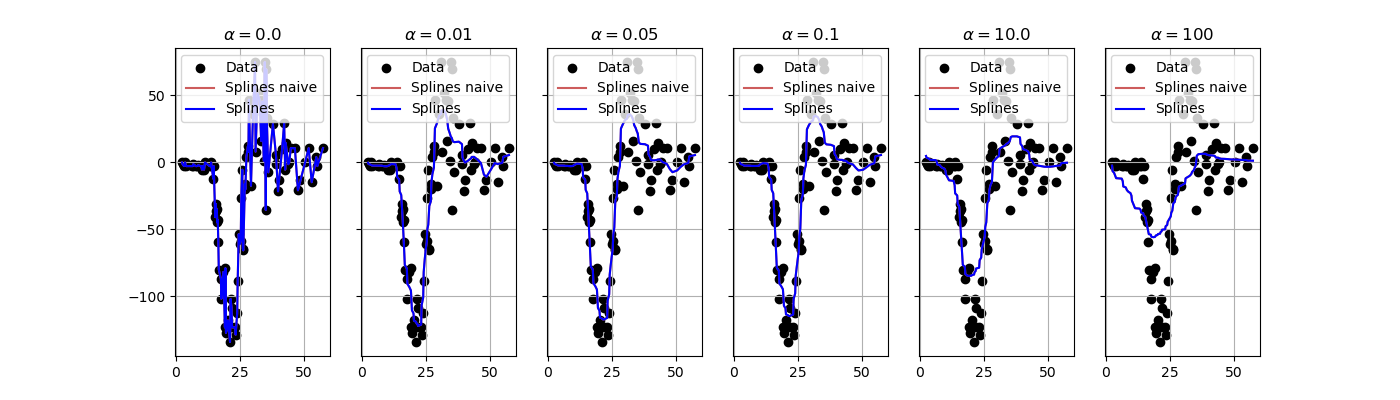

In [252]:
alphas = [0., 0.01, 0.05, 0.1, 10., 100]
f, axes = plt.subplots(1, 6, figsize=(14, 4), sharey=True)
for ax, alpha in zip(axes, alphas):
    g, gamma = solve_splines_naive(x, y, weights=weights_norm, alpha=alpha)
    g1, gamma1 = solve_splines(x, y, weights=weights_norm, alpha=alpha)
    ax.scatter(x, y, color="k", label="Data")
    ax.plot(x, g, color="indianred", label="Splines naive")
    ax.plot(x, g1, color="blue", label="Splines")
    ax.set_title(rf"$\alpha = {alpha}$")
    ax.grid()
    ax.legend()
plt.show()

We have succeded at obtaining the splines with two different methods for calculating it. Furthermore when looking at the figures from above we can realise that both methods give the same results.

#### Question 5
Implement a GCV function that returns the GCV score. Visualize the GCV score as a function of alpha.

For computing the generalized cross-validation we based on these formulas:

$C V(\alpha)=\frac{\sum_{i=1}^n w_i(Y_i-\hat{g}(t_i))^2}{ \left(1-n^{-1}tr(A_W(\alpha) ) \right)^2}$

with:

$A_W(\alpha)=I -\alpha W^{-1} Q\left(R+\alpha Q^T W^{-1} Q\right)^{-1} Q^T$

In [253]:
def gcv(x, y, weights, alphas):
    """Compute GCV score for a grid of alphas"""
    gcv = []
    n = len(x)
    I = np.eye(n)
    # W = np.diag(weights)
    W_inv = np.diag(1/weights)
    R, Q = _construct_R_Q(x=x)
    Q_tras = Q.T
    R_inv = np.linalg.inv(R)
    #K = Q @ R_inv @ Q_tras
    
    for alpha in alphas:
        g, gamma = solve_splines(x=x, y=y, weights=weights, alpha=alpha)
        # A = (W + alpha*K) @ W
        A_w = I - alpha * W_inv @ Q @ np.linalg.inv( R + alpha * Q_tras @ W_inv @ Q ) @ Q_tras
        tr_A = np.trace( A_w )
        aux = 1/n * np.sum( weights * (y-g)**2) /  (1 - tr_A/n)**2
        gcv.append(aux)

    return np.asarray(gcv)


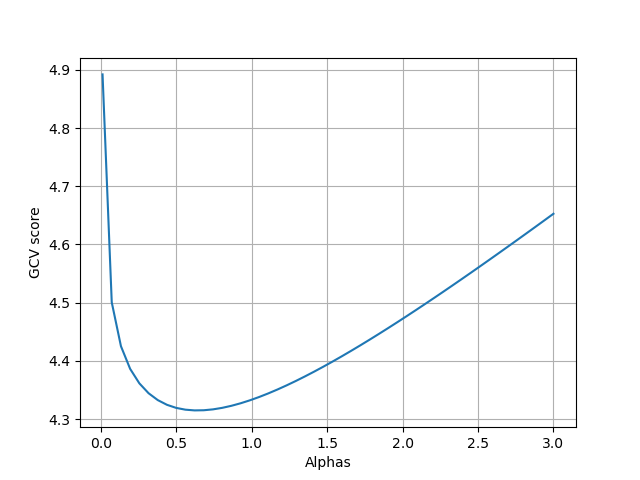

In [254]:
alphas = np.linspace(0.01,3)
gcv_scores = gcv( x, y, weights=weights_norm , alphas= alphas)

fig, ax = plt.subplots()
plt.plot(alphas, gcv_scores )
plt.xlabel("Alphas")
plt.ylabel("GCV score")
plt.grid()
plt.show()

The figure from above gives us good information, most specificaly we can know what is the best alpha to choose in this problem. If we see the figures from question 4 we can see that reasonable splines where done for alphas in the same range that we have in here, so that makes us think that the obtained results are consistent.

### Custom regressor and cross validation with scikit-learn
To evaluate the best polynomial fit using cross-validation, we write our own scikit-learn and use scikit-learn's GridSearchCV to perform cross-validation. 

#### Question 6
Fill the class below and find the best Polynomial fit:


In [255]:
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.model_selection import GridSearchCV, LeaveOneOut

class PolynomialFit(BaseEstimator, RegressorMixin):
    def __init__(self, degree=5):
        self.degree = degree
        
    def fit(self, x, y, weights=None):
        self.coef = np.polyfit(x ,y ,deg = self.degree, w=weights)
        return self

    def predict(self, x):
        return np.polyval(self.coef, x)
    
    def score(self, x, y):
        pass

params = {"degree": np.arange(16)}

cv = LeaveOneOut()
poly_cv = GridSearchCV(PolynomialFit(), params, cv=cv, scoring="neg_mean_squared_error")
poly_cv.fit(x, y)
poly_cv.best_estimator_

PolynomialFit(degree=8)

#### Question 7
See the content of `poly_cv.cv_results_` and plot the mean CV score as a function of the degree. 

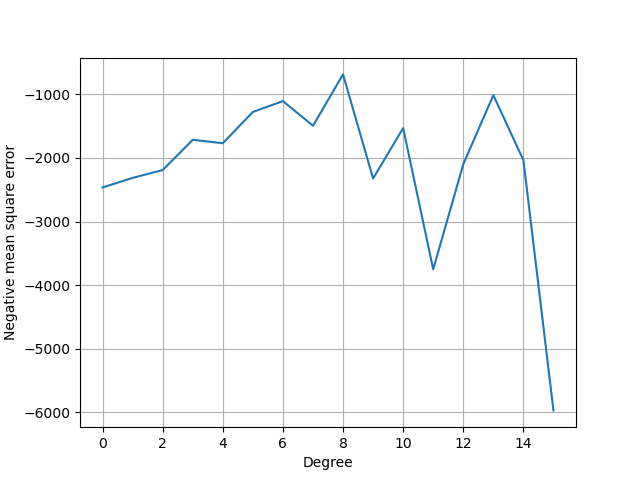

In [256]:
cv_results = pd.DataFrame(poly_cv.cv_results_)

fig, ax = plt.subplots()
plt.plot(cv_results["param_degree"], cv_results["mean_test_score"] )
plt.xlabel("Degree")
plt.ylabel("Negative mean square error")
plt.grid()
plt.show()


We remark that we are using the GridSearchCV with a negative score strategy to evaluate the performance of the cross-validated model on the test set. So here we can why the best degree was chosen 8, as the negative mean test score is the highest, or equivalently the positive mean test score is the lowest in terms of mean square error.

#### Question 8
Visualize the obtained best polynomial fit as well as the best cubic spline given by the GCV score minimizer.

The best alpha found is:  0.6202040816326531


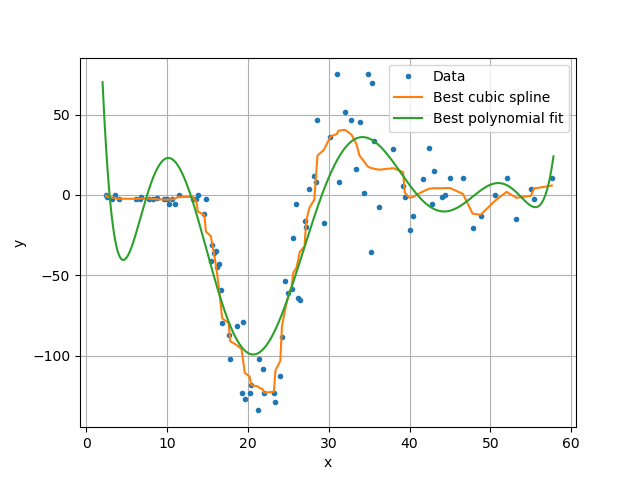

In [257]:
# Calculate Best Polynomial Fit
coef = np.polyfit(x, y, 8 , w=weights**0.5)
polyreg = np.poly1d(coef)

# Calculate Best Cubic Spline
idx = np.argmin(gcv_scores)
best_alpha = alphas[idx]
print("The best alpha found is: " , best_alpha)
g, gamma = solve_splines(x=x, y=y, weights=weights, alpha=best_alpha)


fig, ax = plt.subplots()
plt.plot(x,y, '.', label = "Data")
plt.plot(x,g , label = "Best cubic spline")
plt.plot(xx, polyreg(xx), label = "Best polynomial fit")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

We can see from the figure above that both regressions fit the data, however as discussed before the polynomial fit have great problems fitting the data on the extremes, while the cubic splines does a great overall fitting.

#### Question 9
Scikit-learn pipelines can be used to serialize several operations or models in one estimator. For ex:
```from sklearn.pipeline import Pipeline
pip = Pipeline([("Model_1_Name", Model1), ("Model_2_Name", Model2)])
pip.fit(X, y) ....
```
Using scikit-learn's `PolynomialFeatures` transformator, write a model that performs a polynomial.

In [258]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [259]:
pipe = Pipeline([('poly', PolynomialFeatures(5)), ('polyfit', LinearRegression())])
pipe.fit(x.reshape(-1, 1),y)




Pipeline(steps=[('poly', PolynomialFeatures(degree=5)),
                ('polyfit', LinearRegression())])

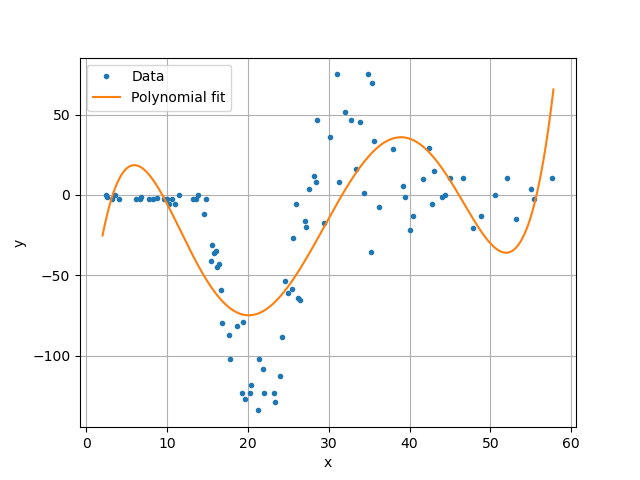

In [260]:
fig, ax = plt.subplots()
plt.plot(x,y, '.', label = "Data")
plt.plot(xx, pipe.predict(xx.reshape(-1,1)), label = "Polynomial fit")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

#### Question 10
Perform cross validation on the degree of this model using scikit-learn.

In [261]:
pipeline = Pipeline(steps=[('poly', PolynomialFeatures()), ('polyfit', LinearRegression())])

params = {"poly__degree": np.arange(12)}

pipeline_cv = GridSearchCV(pipeline, param_grid=params, cv=cv, scoring="neg_mean_squared_error")
pipeline_cv.fit(x.reshape(-1,1), y)
pipeline_cv.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures(degree=8)),
                ('polyfit', LinearRegression())])

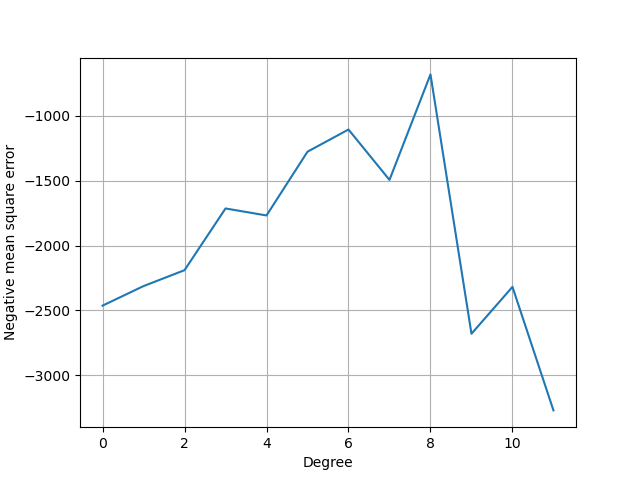

In [262]:
pipeline_cv_results = pd.DataFrame(pipeline_cv.cv_results_)

fig, ax = plt.subplots()
plt.plot(pipeline_cv_results["param_poly__degree"], pipeline_cv_results["mean_test_score"] )
plt.xlabel("Degree")
plt.ylabel("Negative mean square error")
plt.grid()
plt.show()

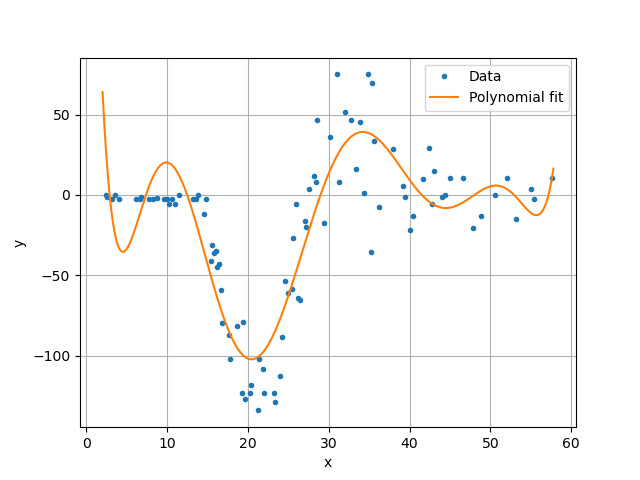

In [263]:
yy = pipeline_cv.best_estimator_.predict(xx.reshape(-1,1))

fig, ax = plt.subplots()
plt.plot(x,y, '.', label = "Data")
plt.plot(xx, yy, label = "Polynomial fit")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

It was effectively implemented the cross validation for the pipeline model, we obtained the same results as before.

#### Question 11
Find the analytical expression of the NCS given $g$ and $\gamma$ to evaluate it on any data point $x$. Visualize it on a grid of a few hundred regular points.

This is the analytical expression of the NCS given g and $\gamma$, inside the range of the knots [t1, tn], for i = 1, ... , n-1 define $h_i = t_{i+1}- t_i$ :

$\begin{aligned} & g(t)= \frac{\left(t-t_i\right) g_{i+1}+\left(t_{i+1}-t\right) g_i}{h_i}  -\frac{1}{6}\left(t-t_i\right)\left(t_{i+1}-t\right)\left\{\left(1+\frac{t-t_i}{h_i}\right) \gamma_{i+1}+\left(1+\frac{t_{i+1}-t}{h_i}\right) \gamma_i\right\} \\ & \text { for } t_i \leq t \leq t_{i+1}, i=1, \ldots, n-1 .\end{aligned}$


The linearity of g outside the range of the knots gives:

$$
g(t)=g_1-\left(t_1-t\right) g^{\prime}\left(t_1\right) \text { for } t \leq t_1
$$
and
$$
g(t)=g_n+\left(t-t_n\right) g^{\prime}\left(t_n\right) \text { for } t \geq t_n .
$$

With:

$$
g^{\prime}\left(t_1\right)=\frac{g_2-g_1}{t_2-t_1}-\frac{1}{6}\left(t_2-t_1\right) \gamma_2
$$
and
$$
g^{\prime}\left(t_n\right)=\frac{g_n-g_{n-1}}{t_n-t_{n-1}}+\frac{1}{6}\left(t_n-t_{n-1}\right) \gamma_{n-1} .
$$

References:
[1]

In [264]:
def draw_NCS(x, y, weights, alpha):
    
    g, gamma = solve_splines(x=x, y=y, weights=weights, alpha=alpha)
    xx = np.linspace(x.min(), x.max(), 1000)
    yy = np.zeros_like(xx)
    g_prime_1 = (g[1] - g[0]) / (x[1] - x[0]) - 1/6 * (x[1] - x[0]) * gamma[0]
    g_prime_n = (g[-1] - g[-2]) / (x[-1] - x[-2]) + 1/6 * (x[-1] - x[-2]) * gamma[-1]
    for i in range(len(xx)):
        if xx[i] < x[1]:
            yy[i] = g[0] - g_prime_1 * (x[0] - xx[i])
        elif xx[i] > x[-2]:
            yy[i] = g[-1] + g_prime_n * (xx[i] - x[-1])
        else:
            for k in range(1, len(x)-3):
                if x[k] <= xx[i] <= x[k+1]:
                    hi = x[k+1] - x[k]
                    yy[i] = 1/hi * (g[k] * (x[k+1] - xx[i]) + g[k+1] * (xx[i] - x[k])) - 1/6 * (xx[i] - x[k]) * (x[k+1] - xx[i]) * ( gamma[k] * (1 + (x[k+1] - xx[i]) / hi ) + gamma[k+1] * (1 + (xx[i] - x[k]) / hi) )
    
    
    fig, ax = plt.subplots()
    plt.plot(x,y, '.', label = "Data")
    plt.plot(xx, yy,  label = "Splines fit")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid()
    plt.show()
    
    
    return



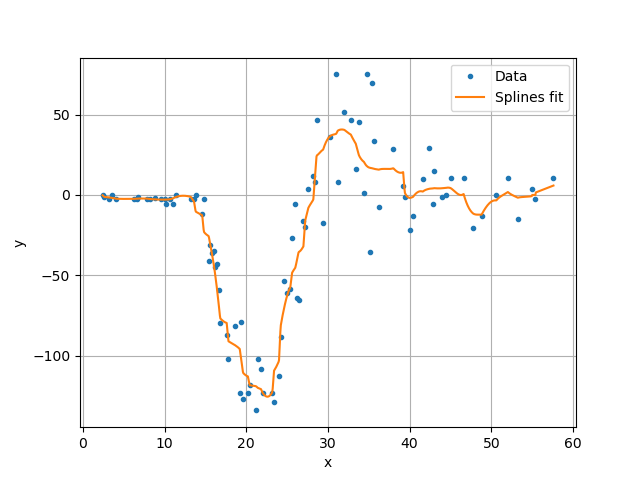

In [265]:
draw_NCS(x, y, weights = weights, alpha=best_alpha)

It was effectively computed the plot of the NCS, the data used was the same as the one we have been working with so that we have a good point of reference to see if the results are good. Once again the expected result was achieved.

## References:

[1] Green, P.J., & Silverman, B.W. (1993). Nonparametric Regression and Generalized Linear Models: A roughness penalty approach (1st ed.). Chapman and Hall/CRC. https://doi.org/10.1201/b15710